In diesem Notebook werden auf verschiedenen Modalitäten verschiedene Modelle trainiert, angewendet und ausgewertet. Jeweils: Random Forest, XGBoost, Logistic Regression, SVM, Neuronales Netz

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Vorbereitung: Data Split in 3 Datasets!

Preprocessing der Kategorsischen Variablen..

In [ ]:
df = pd.read_csv("features_enriched_tab_img_text.csv")

df = df.rename(
    columns={
        "stars": "tab_star",
        "year": "tab_year",
        "month": "tab_month",
        "day": "tab_day",
        "likesCount": "tab_likesCount",
        "reviewerNumberOfReviews": "tab_reviewerNumberOfReviews",
        "isLocalGuide": "tab_isLocalGuide",
        "dayofweek": "tab_dayofweek",
        "elapsed_days": "tab_elapsed_days",
        "when_on_day_4hbin": "tab_when_on_day_4hbin",
    }
)

df["label"] = df["label"].replace({"real": 0, "fake": 1})
df["text_sentiment"] = df["text_sentiment"].replace(
    {"positive": 0, "negative": 1, "neutral": 2}
)

df_num = df.select_dtypes(include=["float64", "int64"])
df_cat = df.select_dtypes(include=["object"])

df.to_csv("features_enriched_tab_img_text_preproc.csv", index=False)

In [2]:
df = pd.read_csv("features_enriched_tab_img_text_preproc.csv")
# print the tab_isLocalGuide column
# get all text 
print(df.filter(regex='text_'))

      text_length  text_length_char  text_punctuation  text_avg_word_length  \
0              53               261                 3              3.905660   
1              11                54                 0              3.818182   
2              19                96                 0              4.000000   
3              61               329                 6              4.377049   
4              23               128                 2              4.521739   
...           ...               ...               ...                   ...   
1401            5                26                 0              4.400000   
1402           15                84                 3              4.666667   
1403            6                34                 1              4.833333   
1404           10                63                 4              5.400000   
1405           42               228                 4              4.452381   

      text_avg_sentence_length  text_sentiment  tex

In [3]:
df = pd.read_csv('features_enriched_tab_img_text_preproc.csv')
print(f"Orginal:\t{df.shape}")
print("---------------------------------------------------------------------------------------------")

train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train_val, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val['label'], random_state=1)
print(f"Train:\t\t{train.shape}")
print(f"Validation:\t{val.shape}")
print(f"Test:\t\t{test.shape}")

train.to_csv('detection_train.csv', index=False)
val.to_csv('detection_val.csv', index=False)
test.to_csv('detection_test.csv', index=False)

Orginal:	(1406, 564)
---------------------------------------------------------------------------------------------
Train:		(899, 564)
Validation:	(225, 564)
Test:		(282, 564)


# Text

Nur aufgrund der Text-Features vorhersagen treffen.

RandomForest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv('detection_train.csv')
used_features = train_df.filter(regex='^(tab_)').columns

used_features = used_features.drop('tab_elapsed_days')
used_features = used_features.drop('tab_reviewerNumberOfReviews')

X_train = train_df[used_features]
y_train = train_df['label']

rfc = RandomForestClassifier(random_state=1, max_depth=3, n_estimators=1000 )
rfc.fit(X_train, y_train)

val_df = pd.read_csv('detection_val.csv')
X_val = val_df.filter(used_features)
y_val = val_df['label']

y_pred = rfc.predict(X_val)

test_df = pd.read_csv('detection_test.csv')
X_test = test.filter(used_features)
y_test = test['label']

y_pred_test = rfc.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation set accuracy: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test set accuracy: {accuracy}")

XGBoost

Validation set accuracy: 0.72
Test set accuracy: 0.7907801418439716


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


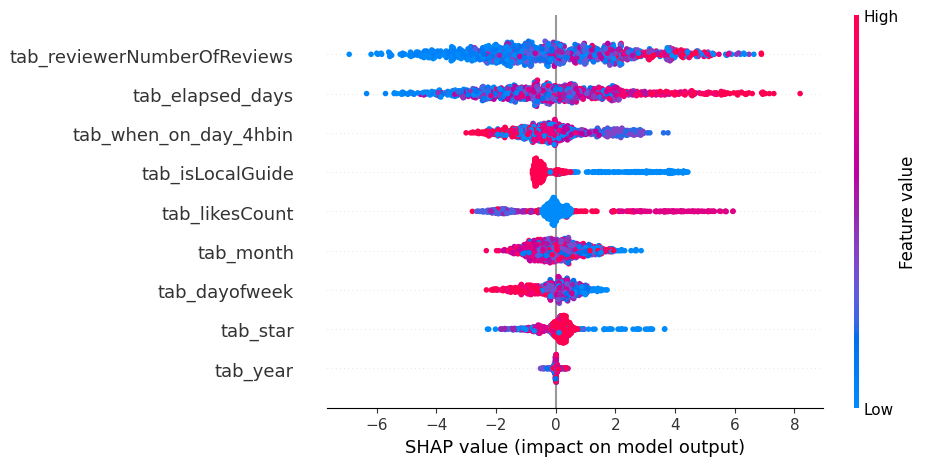

<Figure size 640x480 with 0 Axes>

In [15]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import shap

train_df = pd.read_csv('detection_train.csv')
val_df = pd.read_csv('detection_val.csv')
test_df = pd.read_csv('detection_test.csv')

used_features = train_df.filter(regex='^(tab_)').columns

X_train, y_train = train_df[used_features], train_df['label']
X_val, y_val = val_df[used_features], val_df['label']
X_test, y_test = test_df[used_features], test_df['label']

xgb = XGBClassifier(random_state=1, max_depth=3, n_estimators=1000)
xgb.fit(X_train, y_train)

y_pred_val = xgb.predict(X_val)
y_pred_test = xgb.predict(X_test)


accuracy_val = accuracy_score(y_val, y_pred_val)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Validation set accuracy: {accuracy_val}")
print(f"Test set accuracy: {accuracy_test}")

# feature_importances = xgb.feature_importances_

# feature_df = pd.DataFrame({'feature': used_features, 'importance': feature_importances})

# # Sort the DataFrame by importance in descending order
# feature_df = feature_df.sort_values(by='importance', ascending=False)
# feature_df = feature_df.head(120)

# # Plot the feature importances in a bar chart
# sns.set_style("whitegrid")
# plt.figure(figsize=(18, 18))
# sns.barplot(x='importance', y='feature', data=feature_df)
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importances')
# plt.show()


# shap analysis

import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Load the SHAP values
# drop na values
X_train = X_train.dropna()
X_test = X_test.dropna()
X_val = X_val.dropna()

explainer = shap.Explainer(xgb)
shap_values = explainer(X_train)

# shap.summary_plot(shap_values[:1000,:], X_train.iloc[:1000,:], plot_type="layered_violin", color='coolwarm')
#shap.summary_plot(shap_values[:1000,:], X_train.iloc[:1000,:], color='coolwarm', show=False)
plt.tight_layout()

shap.plots.beeswarm(shap_values, max_display=20)

plt.show()
plt.savefig('shap_tab_plot.pdf')


# Tabular

# Image

# Multimodal